[toc]

# 0.基本库导入

In [41]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# 1.图片导入rgb以及展示

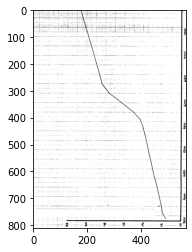

In [42]:
pic=cv.imread('demo2.png')
plt.imshow(pic)
plt.show()

# 2.灰度化并展示

size of pic is :  M= 811   N= 568

the gray pic is :
 [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 180]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

the color type of pic is :
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178

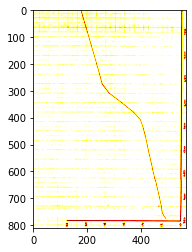

In [43]:
pic_gray=cv.cvtColor(pic,cv.COLOR_BGR2GRAY) #灰度化
pic_mat=np.array(pic_gray) #数组化
M,N=np.shape(pic_mat) #获得数组大小
np.savetxt('demo2.txt',pic_mat,fmt='%d') #存入txt方便看
list_gray=np.unique(pic_mat) #这是所有灰度值
print('size of pic is :  M=',M,'  N=',N)
print('\nthe gray pic is :\n',pic_mat)
print('\nthe color type of pic is :\n',list_gray)
plt.imshow(pic_mat,cmap=plt.cm.hot)
plt.show()

# 3.根据灰度值初筛选

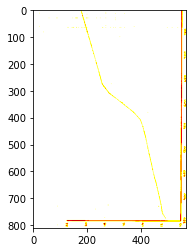

In [44]:
filter0=np.zeros([M,N])+1 #没颜色的地方设置为0
for j in range(M):
    for i in range(N):
        if pic_mat[j][i]<10: #这里的10就为初始筛选值
            filter0[j][i]=0 #有颜色的地方设置为1
            pass
        pass
    pass
plt.imshow(filter0,cmap=plt.cm.hot)
plt.show()

# 4.自动获取零点算法M0,N0=get0(mat)

In [45]:
def get0(mat):
    M,N=np.shape(mat)
    Sum=np.zeros([M,N])+M*N
    for j in range(1,M-1):
        for i in range(1,N-1):
            Sum[j][i]=0
            Sum[j][i]+=mat[j-1].sum()
            Sum[j][i]+=mat[j].sum()
            Sum[j][i]+=mat[j+1].sum()
            Sum[j][i]+=mat.T[i-1].sum()
            Sum[j][i]+=mat.T[i].sum()
            Sum[j][i]+=mat.T[i+1].sum()
            pass
        pass
    pos=np.argmin(Sum)
    M0=int(pos/N)
    N0=pos-N*M0
    return M0,N0
    pass
M0,N0=get0(filter0)

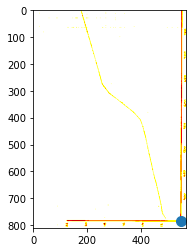

In [47]:
plt.imshow(filter0,cmap=plt.cm.hot)
plt.scatter(N0,M0,s=100)
plt.show()

# 5.另外两点的获取

- (784,550)->(350,10)
- (784,125)->(350,22)
- (0,552)->(800,10)

In [48]:
def Trans(ij,xy):
    i1,j1,i2,j2,i3,j3=ij
    x1,y1,x2,y2,x3,y3=xy
    A=np.array([
        [i1,j1,1],
        [i2,j2,1],
        [i3,j3,1]
    ])
    invA=np.linalg.inv(A)
    q11,q21,x0=invA.dot(np.array([x1,x2,x3]))
    q12,q22,y0=invA.dot(np.array([y1,y2,y3]))
    q=np.array([
        [q11,q21],
        [q12,q22]
    ])
    xy0=np.array([[x0],[y0]])
    return q,xy0
    pass

In [49]:
demo_ij=np.array([784,550,784,125,0,552])
demo_xy=np.array([350,10,350,22,800,10])
demo_q,demo_xy0=Trans(demo_ij,demo_xy)
print('q=\n',demo_q,'\n')
print('xy0=\n',demo_xy0,'\n')

q=
 [[-5.73979592e-01  1.60901888e-16]
 [-7.20288115e-05 -2.82352941e-02]] 

xy0=
 [[800.        ]
 [ 25.58588235]] 



# 6.提取点

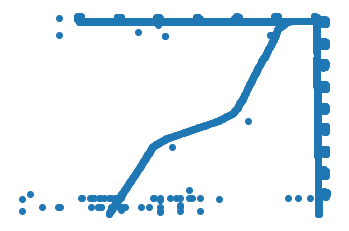

In [52]:
listx=list()
listy=list()
for j in range(M):
    for i in range(N):
        if filter0[j][i]==0:
            listx.append(i)
            listy.append(j)
            pass
        pass
    pass
xi=np.array(listx)
yj=np.array(listy)
plt.scatter(xi,yj)
plt.axis('off')
plt.show()